# <b>PAI CA2</b>
Name: Yongjie, Jovan, QingYang & Rejey

---

In this notebook, we will be continuing from where we left off from CA1 where we have already cleaned the dataset (notebook can be found in submission as well). Here, we will be training a machine learning model to detect fraud activities and expeimenting with Dask, outliers and sampling techniques to see if it helps our model creation process

### <b>Steps to Complete Before Training</b>

1. **Merge** the dataset.
2. Check for **target imbalance**.
3. Handle **categorical data**.
4. **Scale** the data.
5. Experiment with different **outlier** removal techniques.
6. Handle **imbalanced data** (if present) by experimenting with different techniques.
7. Define evaluation metrics.
8. Use **Dask** to create a pipeline for model training.
9. Train different models.
10. Perform hyperparameter tuning on the models.

---
### <b>Import Necessary Libraries</b>
---

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.compose import ColumnTransformer

import warnings
from urllib.parse import urlparse

import mlflow
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import itertools


# Show all columns
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

---
### <b>Loading data from SQL Database</b>
---

##### Create connection to SQL DB

In [2]:
# %%time

# ## SQL Server Name and Database Name
# server = 'yj\SQLEXPRESS'
# database = 'PAI_CA1'

# ## Create a connection to the SQL Server
# engine = create_engine('mssql+pyodbc://{}/{}?driver=ODBC Driver 17 for SQL Server'.format(server, database))

# customer_df = pd.read_sql('SELECT * FROM [dbo].[clean-data-customer_v1.0]', engine)
# order_df = pd.read_sql('SELECT * FROM [dbo].[clean-data-order_v1.0]', engine)
# label_df = pd.read_sql('SELECT * FROM [dbo].[clean-data-label_v1.0]', engine)

---

### <b>Merge the datasets</b>

---

In [3]:
# # Drop index column
# customer_df.drop(columns=['index'], inplace=True)
# order_df.drop(columns=['index'], inplace=True)
# label_df.drop(columns=['index'], inplace=True)

In [4]:
# # merge the data
# merged_df = pd.merge(label_df, customer_df, on=['customer_id', 'country_code'], how='inner')
# merged_df = pd.merge(merged_df, order_df, on=['order_id', 'country_code'], how='inner')

# merged_df.to_csv('merged_data.csv', index=False)

In [5]:
data = pd.read_csv('./data/merged_data.csv')

merged_df=data.copy()

In [6]:
merged_df

,country_code,order_id,customer_id,is_fraud,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime,collect_type,payment_method,order_value,num_items_ordered,refund_value,order_date
0,BD,w2lx-myz3,bdpr8uva,0,True,0,0,0,0.000000,3,2022-08-13 03:53:52,delivery,PayOnDelivery,8.664062,9,0.870117,2023-04-08
1,BD,ta7z-r91q,bd59rlzo,0,True,7,0,0,228.042468,4,2022-05-08 14:29:19,delivery,CreditCard,21.859375,4,2.279297,2023-02-13
2,BD,t5af-wgb2,bd6zhjvq,0,True,4,1,0,45.674685,2,2021-08-25 07:47:00,delivery,AFbKash,7.125000,1,2.349609,2023-03-06
3,BD,sibu-9lm4,bd4fv4rb,0,True,19,0,3,279.805231,5,2021-12-06 13:53:22,delivery,CreditCard,4.535156,5,0.150024,2023-01-29
4,BD,we61-omtr,bdzeepq7,0,True,30,6,4,107.067610,5,2020-07-04 11:45:39,delivery,PayOnDelivery,3.011719,1,3.750000,2023-01-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263675,PK,s2go-o04o,pkn8lcvq,1,True,0,0,0,0.000000,1,2022-03-07 09:33:11,delivery,GenericCreditCard,3.732422,1,0.000000,2022-12-27
2263676,PK,wepx-o8p9,pkmv7mxc,1,True,2,0,0,12.462575,3,2021-01-16 15:59:39,delivery,PayOnDelivery,1.310547,1,0.000000,2023-04-10
2263677,PK,jvd2-zdf0,pkdgo2zl,1,True,3,0,0,8.599665,3,2019-08-04 14:20:44,delivery,PayOnDelivery,1.414062,2,0.000000,2023-05-05
2263678,PK,kca0-drm6,pkovsmz7,1,True,29,2,0,204.568653,2,2021-12-02 16:24:04,delivery,PayOnDelivery,7.316406,4,0.000000,2023-04-13


In [10]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


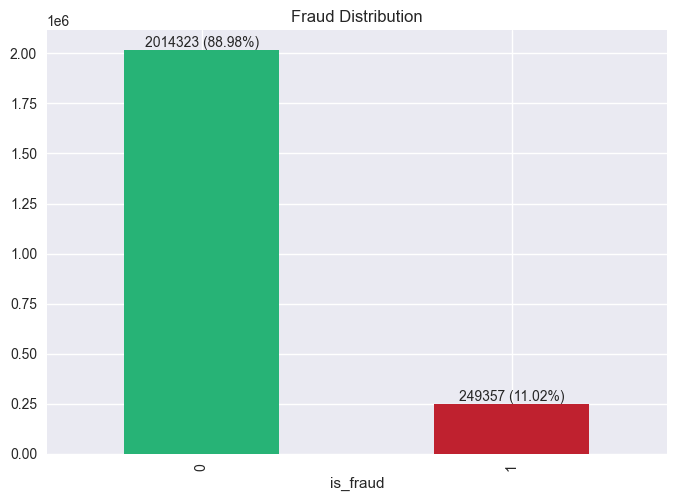

In [15]:
# plot bar graph of the target variable
import matplotlib.pyplot as plt
import seaborn as sns
# set palette
plt.style.use('seaborn-v0_8')  # or another valid style
merged_df['is_fraud'].value_counts().plot(kind='bar', color=['#27b376', '#bf212f'])
# add percentage to the plot
total = merged_df.shape[0]
for i in range(2):
    count = merged_df['is_fraud'].value_counts().values[i]
    plt.text(i, count, f'{count} ({count/total*100:.2f}%)', ha='center', va='bottom')
plt.title('Fraud Distribution')
plt.show()

In [6]:
merged_df.head()

,country_code,order_id,customer_id,is_fraud,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime,collect_type,payment_method,order_value,num_items_ordered,refund_value,order_date
0,BD,w2lx-myz3,bdpr8uva,0,True,0,0,0,0.000000,3,2022-08-13 03:53:52,delivery,PayOnDelivery,8.664062,9,0.870117,2023-04-08
1,BD,ta7z-r91q,bd59rlzo,0,True,7,0,0,228.042468,4,2022-05-08 14:29:19,delivery,CreditCard,21.859375,4,2.279297,2023-02-13
2,BD,t5af-wgb2,bd6zhjvq,0,True,4,1,0,45.674685,2,2021-08-25 07:47:00,delivery,AFbKash,7.125000,1,2.349609,2023-03-06
3,BD,sibu-9lm4,bd4fv4rb,0,True,19,0,3,279.805231,5,2021-12-06 13:53:22,delivery,CreditCard,4.535156,5,0.150024,2023-01-29
4,BD,we61-omtr,bdzeepq7,0,True,30,6,4,107.067610,5,2020-07-04 11:45:39,delivery,PayOnDelivery,3.011719,1,3.750000,2023-01-16


In [7]:
import pandas as pd

def convert_dtypes(df):
    # Convert 'order_value' and 'refund_value' to float16 for memory efficiency
    df['order_value'] = df['order_value'].astype('float16')
    df['refund_value'] = df['refund_value'].astype('float16')
    
    # Convert 'num_items_ordered' to uint8 after rounding
    df['num_items_ordered'] = df['num_items_ordered'].astype(float).round().astype('uint8')
    
    # Convert 'order_date' and 'first_order_datetime' to datetime
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['first_order_datetime'] = pd.to_datetime(df['first_order_datetime'])
    
    # Convert categorical columns to category dtype for efficiency
    df[['country_code', 'collect_type', 'payment_method']] = df[['country_code', 'collect_type', 'payment_method']].astype('category')
    
    # Convert numerical columns (those that represent counts or numeric features) to uint16
    df[['num_orders_last_50days', 'num_cancelled_orders_last_50days', 'num_refund_orders_last_50days']] = df[['num_orders_last_50days', 'num_cancelled_orders_last_50days', 'num_refund_orders_last_50days']].astype('uint16')
    
    # Convert 'num_associated_customers' to uint8 for efficient memory usage
    df['num_associated_customers'] = df['num_associated_customers'].astype('uint8')
    
    # Convert 'total_payment_last_50days' to float16 for memory efficiency
    df['total_payment_last_50days'] = df['total_payment_last_50days'].astype('float16')
    
    # Convert 'mobile_verified' and 'is_fraud' columns to boolean (mapping string values)
    # df['mobile_verified'] = df['mobile_verified'].map({'True': True, 'False': False})
    # df['is_fraud'] = df['is_fraud'].map({'1': True, '0': False})
    
    return df

merged_df = convert_dtypes(merged_df)

In [8]:
merged_df.dtypes

country_code                              category
order_id                                    object
customer_id                                 object
is_fraud                                     int64
mobile_verified                               bool
num_orders_last_50days                      uint16
num_cancelled_orders_last_50days            uint16
num_refund_orders_last_50days               uint16
total_payment_last_50days                  float16
num_associated_customers                     uint8
first_order_datetime                datetime64[ns]
collect_type                              category
payment_method                            category
order_value                                float16
num_items_ordered                            uint8
refund_value                               float16
order_date                          datetime64[ns]
dtype: object

---

### <b>Checking for Imbalance Data</b>

---

In [9]:
## Check for imbalance data for is_fraud in data_dd

print(merged_df['is_fraud'].value_counts(), '\n')

# Check percentage of fraud transactions
fraud_percentage = merged_df['is_fraud'].mean() * 100
print(f'Percentage of fraud transactions: {fraud_percentage:.2f}%')

is_fraud
0    2014323
1     249357
Name: count, dtype: int64 

Percentage of fraud transactions: 11.02%


The target variable `is_fraud` exhibits an expected **imbalance**, as fraud cases naturally constitute only a small proportion of the overall data. Hence, later on we can apply different techniques to try and deal with the imbalance data to see if it helps improves accuracy.

---

### **Train Test-Split**

---

Before splitting, we will drop the redudant columns

In [10]:
merged_df.drop(columns=['order_id', 'customer_id'], inplace=True)

In [11]:
X=merged_df.drop(columns=['is_fraud'])
y=merged_df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_train.dtypes

country_code                              category
mobile_verified                               bool
num_orders_last_50days                      uint16
num_cancelled_orders_last_50days            uint16
num_refund_orders_last_50days               uint16
total_payment_last_50days                  float16
num_associated_customers                     uint8
first_order_datetime                datetime64[ns]
collect_type                              category
payment_method                            category
order_value                                float16
num_items_ordered                            uint8
refund_value                               float16
order_date                          datetime64[ns]
dtype: object

We will create a copy of X_train to test our preprocessing steps, ensuring that the original data remains unchanged and unaffected by any transformations.

In [13]:
X_train_preprocessed = X_train.copy()

---

### <b> Handling the Categorical, Datetime & String Data

---

##### Data Transformation for Model Development

Before building our models, we need to preprocess the data by transforming categorical and datetime features into numerical formats using techniques such as one-hot encoding and more. Below is an overview of the columns in our dataset:

#### Categorical Features
- **`country_code`**: Contains 5 unique categories.
- **`collect_type`**: Contains 2 unique categories.
- **`payment_method`**: Contains 18 unique categories.

#### Datetime Features
- **`order_date`**: Needs to be transformed into a numerical format.
- **`first_order_datetime`**: Requires conversion for numerical representation.

These transformations will ensure the data is suitable for machine learning models.

##### **Dealing with Categorical Features**

Since payment_method contains more than 18 different categories, by one_hot_encoding it, it may result in too many columns can make it harder for models to learn meaningful patterns, lead to longer training times and potential overfitting. Therefore, we will be grouping up the payment_methods.

In [14]:
X_train_preprocessed['payment_method'].value_counts()

payment_method
PayOnDelivery            596345
CybersourceCreditCard    258894
RazerOnlineBanking       238417
CreditCard               216079
AFGCash                  196703
GenericCreditCard        138016
AccountBalance            49428
AFTNG                     41232
AFbKash                   33617
AFTrueMoney               17443
AdyenBoost                11670
JazzCashWallet             4691
Invoice                    3902
AdyenMolpay                1507
NoPayment                  1262
CybersourceApplePay        1059
PayPal                      672
XenditDirectDebit             7
Name: count, dtype: int64

In [15]:
def group_payment_methods(payment_method):
    # Credit Card and Related Gateways
    if payment_method in ['GenericCreditCard', 'CybersourceCreditCard', 'CybersourceApplePay', 'CreditCard']:
        return 'CreditCard'
    
    # Digital Wallets
    elif payment_method in ['GCash', 'AFbKash', 'JazzCashWallet', 'AFTrueMoney', 'AdyenBoost', 'AdyenMolpay',
                            'AFTNG', 'AdyenHPPBoost', 'AdyenHPPMolpay', 'PayPal', 'AFGCash', 'AccountBalance']:
        return 'DigitalWallet'
    
    # Bank Transfers and Direct Debit
    elif payment_method in ['XenditDirectDebit', 'RazerOnlineBanking']:
        return 'BankTransfer'
    
    # PayOnDelivery
    elif payment_method in ['Invoice', 'PayOnDelivery']:
        return 'PaymentOnDelivery'
    
    # Default case for unrecognized methods
    else:
        return 'Others'


In [16]:
X_train_preprocessed['payment_method'] = X_train_preprocessed['payment_method'].apply(group_payment_methods)

In [17]:
X_train_preprocessed['payment_method'].value_counts()

payment_method
CreditCard           614048
PaymentOnDelivery    600247
DigitalWallet        356963
BankTransfer         238424
Others                 1262
Name: count, dtype: int64

**One-Hot Encode Categorical Cols**

In [18]:
def encode_categorical(df):
    # Initialize encoder
    encoder = OneHotEncoder( sparse_output=False)

    # Fit and transform the categorical columns
    encoded_data = encoder.fit_transform(df[['country_code', 'collect_type', 'payment_method']])
    # print(encoded_data.shape)
    # Convert the result to a DataFrame and assign the correct column names
    encoded_cols = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['country_code', 'collect_type', 'payment_method']))
    # Drop the original categorical columns from the dataframe
    # Concatenate the encoded columns with the rest of the dataframe
    df_encoded = df.drop(columns=['country_code', 'collect_type', 'payment_method'])
    encoded_cols.index = df.index
    df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)
    
    return df_encoded

In [19]:
X_train_encoded = encode_categorical(X_train_preprocessed)

X_train_encoded

,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime,order_value,num_items_ordered,refund_value,order_date,country_code_BD,country_code_MY,country_code_PH,country_code_PK,country_code_TH,collect_type_delivery,collect_type_pickup,payment_method_BankTransfer,payment_method_CreditCard,payment_method_DigitalWallet,payment_method_Others,payment_method_PaymentOnDelivery
1206580,True,205,7,10,1876.000000,2,2019-07-23 02:32:21,6.562500,3,6.558594,2023-01-03,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1879599,True,79,1,2,1374.000000,1,2019-09-18 04:35:00,9.320312,12,2.259766,2022-12-06,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2096251,True,25,1,0,147.875000,2,2022-07-01 11:53:47,4.546875,4,0.350098,2023-02-12,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1481618,True,2,0,0,0.000000,7,2023-04-07 10:50:55,4.242188,5,0.000000,2023-04-07,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
413051,True,0,0,0,3.677734,3,2022-08-31 05:25:05,3.484375,3,0.000000,2022-12-14,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278069,True,3,0,0,23.718750,1,2020-10-23 11:57:30,2.843750,1,0.000000,2023-02-19,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1858733,True,25,0,1,318.000000,1,2020-05-24 07:30:15,2.765625,1,2.769531,2022-12-15,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
994333,True,56,0,2,1149.000000,3,2019-12-23 04:10:20,10.453125,3,10.656250,2022-11-23,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1474920,True,247,10,10,1083.000000,3,2022-09-17 08:19:58,10.156250,1,0.000000,2023-04-04,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


**Handling Datetime Cols**

In [20]:
X_train_preprocessed

,country_code,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime,collect_type,payment_method,order_value,num_items_ordered,refund_value,order_date
1206580,MY,True,205,7,10,1876.000000,2,2019-07-23 02:32:21,delivery,BankTransfer,6.562500,3,6.558594,2023-01-03
1879599,MY,True,79,1,2,1374.000000,1,2019-09-18 04:35:00,delivery,CreditCard,9.320312,12,2.259766,2022-12-06
2096251,PK,True,25,1,0,147.875000,2,2022-07-01 11:53:47,delivery,CreditCard,4.546875,4,0.350098,2023-02-12
1481618,PK,True,2,0,0,0.000000,7,2023-04-07 10:50:55,delivery,CreditCard,4.242188,5,0.000000,2023-04-07
413051,PH,True,0,0,0,3.677734,3,2022-08-31 05:25:05,delivery,CreditCard,3.484375,3,0.000000,2022-12-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278069,MY,True,3,0,0,23.718750,1,2020-10-23 11:57:30,delivery,BankTransfer,2.843750,1,0.000000,2023-02-19
1858733,MY,True,25,0,1,318.000000,1,2020-05-24 07:30:15,delivery,CreditCard,2.765625,1,2.769531,2022-12-15
994333,MY,True,56,0,2,1149.000000,3,2019-12-23 04:10:20,delivery,BankTransfer,10.453125,3,10.656250,2022-11-23
1474920,PK,True,247,10,10,1083.000000,3,2022-09-17 08:19:58,delivery,DigitalWallet,10.156250,1,0.000000,2023-04-04


In [21]:
X_train_preprocessed.dtypes

country_code                              category
mobile_verified                               bool
num_orders_last_50days                      uint16
num_cancelled_orders_last_50days            uint16
num_refund_orders_last_50days               uint16
total_payment_last_50days                  float16
num_associated_customers                     uint8
first_order_datetime                datetime64[ns]
collect_type                              category
payment_method                              object
order_value                                float16
num_items_ordered                            uint8
refund_value                               float16
order_date                          datetime64[ns]
dtype: object

In [22]:
def days_since_first_order(data, order_date_column, first_order_column):
    # Create a feature for the number of days since the first order
    data['days_since_first_order'] = (data[order_date_column] - data[first_order_column]).dt.days
    data.drop([first_order_column], axis=1, inplace=True)
    return data


def transform_datetime(data, column):
    # Handle Datetime columns
    data[column + '_day_of_week'] = data[column].dt.dayofweek
    data[column + '_day'] = data[column].dt.day
    data[column + '_month'] = data[column].dt.month
    data[column + '_year'] = data[column].dt.year
    data.drop([column], axis=1, inplace=True)
    return data

def date_transformations(data):
    data = days_since_first_order(data, 'order_date', 'first_order_datetime')
    data = transform_datetime(data, 'order_date')

    return data

In [23]:
X_train_transform_date = date_transformations(X_train_preprocessed.copy())

X_train_transform_date

,country_code,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,collect_type,payment_method,order_value,num_items_ordered,refund_value,days_since_first_order,order_date_day_of_week,order_date_day,order_date_month,order_date_year
1206580,MY,True,205,7,10,1876.000000,2,delivery,BankTransfer,6.562500,3,6.558594,1259,1,3,1,2023
1879599,MY,True,79,1,2,1374.000000,1,delivery,CreditCard,9.320312,12,2.259766,1174,1,6,12,2022
2096251,PK,True,25,1,0,147.875000,2,delivery,CreditCard,4.546875,4,0.350098,225,6,12,2,2023
1481618,PK,True,2,0,0,0.000000,7,delivery,CreditCard,4.242188,5,0.000000,-1,4,7,4,2023
413051,PH,True,0,0,0,3.677734,3,delivery,CreditCard,3.484375,3,0.000000,104,2,14,12,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278069,MY,True,3,0,0,23.718750,1,delivery,BankTransfer,2.843750,1,0.000000,848,6,19,2,2023
1858733,MY,True,25,0,1,318.000000,1,delivery,CreditCard,2.765625,1,2.769531,934,3,15,12,2022
994333,MY,True,56,0,2,1149.000000,3,delivery,BankTransfer,10.453125,3,10.656250,1065,2,23,11,2022
1474920,PK,True,247,10,10,1083.000000,3,delivery,DigitalWallet,10.156250,1,0.000000,198,1,4,4,2023


---

### **Handling Imbalanced Dataset**

---

**Algorithm-Level Approaches**

1. **Class Weights**
   - Assigns higher weights to the minority class and lower weights to the majority class.
   - No data modification is needed.
   - Useful for algorithms like Logistic Regression, SVM, and Decision Trees.

2. **Custom Models (e.g., XGBoost)**
   - Some models, such as XGBoost, have built-in support for handling imbalanced datasets by using parameters like `scale_pos_weight` to adjust the model’s bias toward the minority class.
   - Can automatically adapt during training to mitigate the effect of class imbalance.

**Data-Level Approaches**

1. **SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous data)**
  - An extension of SMOTE that works with both continuous and categorical features.
   - Creates synthetic samples for the minority class using k-nearest neighbors, ensuring the new samples respect the data's categorical nature.
   - Helps improve the representation of the minority class without duplicating existing samples.

2. **Random Over-Sampling (ROS)**
   - Randomly duplicates samples from the minority class.
   - Simple but can increase the risk of overfitting due to the repetition of samples.

3. **Random Under-Sampling (RUS)**
   - Randomly removes samples from the majority class.
   - While it is fast and reduces the class imbalance, it can cause the loss of valuable data and information.


We will apply the datetime transformation to our training data as the function we will be using are unable to deal with datetime dtypes

In [24]:
X_train_preprocessed = date_transformations(X_train_preprocessed)

In [33]:
X_train_filtered_ISO = pd.read_csv('./data/X_train_filtered_ISO.csv')
y_train_filtered_ISO = pd.read_csv('./data/y_train_filtered_ISO.csv')

X_train_filtered_LOF = pd.read_csv('./data/X_train_filtered_LOF.csv')
y_train_filtered_LOF = pd.read_csv('./data/y_train_filtered_LOF.csv')

**1. SMOTENC**

In [42]:
# Convert categorical columns to 'category' dtype
categorical_columns = ['payment_method', 'country_code', 'collect_type']  # Replace with your actual categorical column names
X_train_filtered_ISO[categorical_columns] = X_train_filtered_ISO[categorical_columns].astype('category')

# Ensure categorical columns are properly encoded before SMOTE
for col in categorical_columns:
    X_train_filtered_ISO[col] = X_train_filtered_ISO[col].cat.codes

# Define which features are categorical (indexes or boolean mask)
categorical_features = [X_train_filtered_ISO.columns.get_loc(col) for col in categorical_columns]

# Apply SMOTENC to the training data
smote = SMOTENC(categorical_features=categorical_features, random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_filtered_ISO, y_train_filtered_ISO)

# Check the results
print(X_train_smote.shape, y_train_smote.shape)

(2927758, 17) (2927758, 1)


In [44]:
# Convert categorical columns to 'category' dtype
categorical_columns = ['payment_method', 'country_code', 'collect_type']  # Replace with your actual categorical column names
X_train_filtered_LOF[categorical_columns] = X_train_filtered_LOF[categorical_columns].astype('category')

# Ensure categorical columns are properly encoded before SMOTE
for col in categorical_columns:
    X_train_filtered_LOF[col] = X_train_filtered_LOF[col].cat.codes

# Define which features are categorical (indexes or boolean mask)
categorical_features = [X_train_filtered_LOF.columns.get_loc(col) for col in categorical_columns]

# Apply SMOTENC to the training data
smote = SMOTENC(categorical_features=categorical_features, random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_filtered_LOF, y_train_filtered_LOF)

# Check the results
print(X_train_smote.shape, y_train_smote.shape)

(3183402, 17) (3183402, 1)


We can see that we now have an even ditribution in fraud cases in our training data

**2. Random Over Sampling**

In [36]:
# Apply RandomOverSampler to the training data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_filtered_ISO, y_train_filtered_ISO)

# Check the results
print(X_train_ros.shape, y_train_ros.shape)

(2927758, 17) (2927758, 1)


In [39]:
# Apply RandomOverSampler to the training data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_filtered_LOF, y_train_filtered_LOF)

# Check the results
print(X_train_ros.shape, y_train_ros.shape)

(3183402, 17) (3183402, 1)


**3. Random Under Sampling**

In [37]:
# Apply RandomUnderSampler to the training data
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_filtered_ISO, y_train_filtered_ISO)

# Check the results
print(X_train_rus.shape, y_train_rus.shape)

(331940, 17) (331940, 1)


In [40]:
# Apply RandomUnderSampler to the training data
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_filtered_LOF, y_train_filtered_LOF)

# Check the results
print(X_train_rus.shape, y_train_rus.shape)

(378402, 17) (378402, 1)


**Saving the Data**

In [43]:
# Save the data as it takes a long time to process
X_train_smote.to_csv('./data/X_train_ISO_smote.csv', index=False)
y_train_smote.to_csv('./data/y_train_ISO_smote.csv', index=False)

# Save y_pred
# y_test.to_csv('./data/y_test.csv', index=False)
# X_test.to_csv('./data/X_test.csv', index=False)

# # Save original data
# X.to_csv('./data/X.csv', index=False)
# y.to_csv('./data/y.csv', index=False)

# # Save X_train and y_train
# X_train.to_csv('./data/X_train.csv', index=False)
# y_train.to_csv('./data/y_train.csv', index=False)

# Save ROS & RUS data as csv
# X_train_ros.to_csv('./data/X_train_ISO_ros.csv', index=False)
# y_train_ros.to_csv('./data/y_train_ISO_ros.csv', index=False)

# X_train_rus.to_csv('./data/X_train_ISO_rus.csv', index=False)
# y_train_rus.to_csv('./data/y_train_ISO_rus.csv', index=False)

In [45]:
# Save the data as it takes a long time to process
X_train_smote.to_csv('./data/X_train_LOF_smote.csv', index=False)
y_train_smote.to_csv('./data/y_train_LOF_smote.csv', index=False)

# Save y_pred
# y_test.to_csv('./data/y_test.csv', index=False)
# X_test.to_csv('./data/X_test.csv', index=False)

# # Save original data
# X.to_csv('./data/X.csv', index=False)
# y.to_csv('./data/y.csv', index=False)

# # Save X_train and y_train
# X_train.to_csv('./data/X_train.csv', index=False)
# y_train.to_csv('./data/y_train.csv', index=False)

# Save ROS & RUS data as csv
# X_train_ros.to_csv('./data/X_train_LOF_ros.csv', index=False)
# y_train_ros.to_csv('./data/y_train_LOF_ros.csv', index=False)

# X_train_rus.to_csv('./data/X_train_LOF_rus.csv', index=False)
# y_train_rus.to_csv('./data/y_train_LOF_rus.csv', index=False)

In [29]:
# import data
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

X_train_smote = pd.read_csv('./data/X_train_smote.csv')
y_train_smote = pd.read_csv('./data/y_train_smote.csv')

X_train_ros = pd.read_csv('./data/X_train_ros.csv')
y_train_ros = pd.read_csv('./data/y_train_ros.csv')

X_train_rus = pd.read_csv('./data/X_train_rus.csv')
y_train_rus = pd.read_csv('./data/y_train_rus.csv')

X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')

In [30]:
X_train.dtypes

country_code                         object
mobile_verified                        bool
num_orders_last_50days                int64
num_cancelled_orders_last_50days      int64
num_refund_orders_last_50days         int64
total_payment_last_50days           float64
num_associated_customers              int64
collect_type                         object
payment_method                       object
order_value                         float64
num_items_ordered                     int64
refund_value                        float64
days_since_first_order                int64
order_date_day_of_week                int64
order_date_day                        int64
order_date_month                      int64
order_date_year                       int64
dtype: object

In [31]:
# apply convert_dtypes
X_test = convert_dtypes(X_test)
X_test = date_transformations(X_test)

### Removing Outliers

In [32]:
### Import Outliers Removing Function OneClassSVM, IsolationForest, LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers(X, y, method='IsolationForest'):
    # Define the outlier detection methods
    outlier_detection_methods = {
        'IsolationForest': IsolationForest(contamination=0.1, random_state=42),
        'OneClassSVM': OneClassSVM(nu=0.1),
        "LocalOutlierFactor": LocalOutlierFactor(n_neighbors=20, novelty=False),
    }

    # Drop categorical columns
    X_numerical = X.select_dtypes(exclude=['category'])

    
    # Get the outlier detection method
    outlier_detection = outlier_detection_methods[method]
    
    # Fit the outlier detection model
    y_pred = outlier_detection.fit_predict(X_numerical)
    
    # Filter the outliers
    X_filtered = X[y_pred == 1]
    y_filtered = y[y_pred == 1]
    
    return X_filtered, y_filtered



In [33]:
import mlflow
import os
import json
from pathlib import Path
import time

class ExperimentTracker:
    def __init__(self, experiment_name, checkpoint_file="experiment_checkpoint.json"):
        self.experiment_name = experiment_name
        self.checkpoint_file = checkpoint_file
        self.completed_runs = self._load_checkpoint()
        
        # Set the environment variables for MLflow (DagsHub credentials)
        os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/UNiTY6969/my-first-repo.mlflow"
        os.environ["MLFLOW_TRACKING_USERNAME"] = "UNiTY6969"
        os.environ["MLFLOW_TRACKING_PASSWORD"] = "cbdafe9f00f18c8e02004a93d7cc250c8c67c96c"
        
        # Set MLflow tracking URI to DagsHub
        remote_server_uri = "https://dagshub.com/UNiTY6969/my-first-repo.mlflow"
        mlflow.set_tracking_uri(remote_server_uri)
        
        # Create or get experiment
        try:
            self.experiment_id = mlflow.create_experiment(experiment_name)
        except Exception:
            self.experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
        
        mlflow.set_experiment(experiment_name)
    
    def _load_checkpoint(self):
        """Load the checkpoint file if it exists."""
        if os.path.exists(self.checkpoint_file):
            with open(self.checkpoint_file, 'r') as f:
                return set(json.load(f))
        return set()
    
    def _save_checkpoint(self):
        """Save the current progress to checkpoint file."""
        with open(self.checkpoint_file, 'w') as f:
            json.dump(list(self.completed_runs), f)
    
    def _generate_run_id(self, config):
        """Generate a unique identifier for a run configuration."""
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        return f"{config['models']['name']}_{config['scaler'].__class__.__name__}_{config['imbalance']['strategy']}_{'encoding' if config['encode']['apply'] else 'no_encoding'}"
    
    def run_experiments(self, experiment_combinations, X_train, y_train, X_test, y_test,
                       X_train_smote, y_train_smote, X_train_ros, y_train_ros,
                       X_train_rus, y_train_rus, numeric_columns, categorical_cols):
        """Run experiments with organized folder structure."""
        
        for config in experiment_combinations:
            run_id = self._generate_run_id(config)
            
            # Skip if this configuration has already been run
            if run_id in self.completed_runs:
                print(f"Skipping completed run: {run_id}")
                continue
            
            print(f"Starting run: {run_id}")
            
            try:
                with mlflow.start_run(run_name=run_id):
                    # Create a more descriptive run name structure
                    run_path = f"{config['models']['name']}/{config['imbalance']['strategy']}/{config['scaler'].__class__.__name__}"
                    mlflow.set_tag("mlflow.runName", run_path)
                    
                    # Add additional tags for better organization
                    mlflow.set_tag("model_type", config['models']['name'])
                    mlflow.set_tag("scaler_type", config['scaler'].__class__.__name__)
                    mlflow.set_tag("imbalance_strategy", config['imbalance']['strategy'])
                    mlflow.set_tag("encoding_applied", str(config['encode']['apply']))

                    # Build preprocessing steps
                    steps = []
                    transformers = []

                    # Apply scaler if specified
                    if config['scaler']:
                        transformers.append(('scaler', config['scaler'], numeric_columns))

                    # Apply encoding if specified
                    if config['encode']['apply']:
                        transformers.append(('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols))
                    else:
                        transformers.append(('drop_categorical', 'drop', categorical_cols))

                    # Apply the preprocessor
                    preprocessor = ColumnTransformer(
                        transformers=transformers,
                        remainder='passthrough'
                    )
                    steps.append(('preprocessor', preprocessor))

                    # Handle imbalance
                    if config['imbalance']['apply']:
                        imbalance_strategy = config['imbalance']['strategy']
                        if imbalance_strategy == 'SMOTE':
                            X_train_resampled, y_train_resampled = X_train_smote, y_train_smote
                        elif imbalance_strategy == 'ROS':
                            X_train_resampled, y_train_resampled = X_train_ros, y_train_ros
                        elif imbalance_strategy == 'RUS':
                            X_train_resampled, y_train_resampled = X_train_rus, y_train_rus
                    else:
                        X_train_resampled, y_train_resampled = X_train, y_train

                    # Select and add model
                    model = config['models']['instance']
                    steps.append(('model', model))

                    # Create and train pipeline
                    pipeline = Pipeline(steps)
                    y_train_resampled = y_train_resampled.to_numpy().ravel()
                    pipeline.fit(X_train_resampled, y_train_resampled)
                    predictions = pipeline.predict(X_test)

                    # Calculate metrics
                    accuracy = accuracy_score(y_test, predictions)

                    # Log to MLflow with additional metrics
                    mlflow.log_params(config)
                    mlflow.log_metric("accuracy", accuracy)
                    mlflow.sklearn.log_model(pipeline, "model", input_example=X_train_resampled.iloc[0:1])

                    # Mark this run as completed
                    self.completed_runs.add(run_id)
                    self._save_checkpoint()
                    
                    print(f"Completed run: {run_id}")
                    
            except Exception as e:
                print(f"Error in run {run_id}: {str(e)}")
                continue

In [39]:
X_train_filtered_LOF, y_train_filtered_LOF = remove_outliers(X_train, y_train, method="LocalOutlierFactor")


In [41]:
# Save the data as it takes a long time to process
X_train_filtered_ISO.to_csv('./data/X_train_filtered_ISO.csv', index=False)
y_train_filtered_ISO.to_csv('./data/y_train_filtered_ISO.csv', index=False)


X_train_filtered_LOF.to_csv('./data/X_train_filtered_LOF.csv', index=False)
y_train_filtered_LOF.to_csv('./data/y_train_filtered_LOF.csv', index=False)

In [53]:
# Define the search space
search_space = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
    'imbalance': [
        {'strategy': 'SMOTE', 'apply': True},
        {'strategy': 'ROS', 'apply': True},
        {'strategy': "RUS", 'apply': True},
        {'strategy': "None",'apply': False}
    ],
    'encode': [{'apply': True, 'columns': ['categorical_col']}, {'apply': False}],
    'models': [
        {'name': 'LogisticRegression', 'instance': LogisticRegression()},
        {'name': 'RandomForest', 'instance': RandomForestClassifier()},
    ]
}

# Generate all combinations of the search space
keys, values = zip(*search_space.items())
experiment_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
categorical_cols = ['payment_method', 'country_code', 'collect_type']
numeric_columns = ['order_value', 'refund_value', 'num_items_ordered', 'num_orders_last_50days', 'num_cancelled_orders_last_50days', 'num_refund_orders_last_50days', 'num_associated_customers', 'total_payment_last_50days', 'days_since_first_order', 'order_date_day_of_week', 'order_date_day', 'order_date_month', 'order_date_year']

In [60]:
# Initialize the tracker
tracker = ExperimentTracker("Testing_Preprocessing_Methods")

# Load checkpoint file
tracker.completed_runs

# Run experiments with checkpointing
tracker.run_experiments(
    experiment_combinations=experiment_combinations,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_train_smote=X_train_smote,
    y_train_smote=y_train_smote,
    X_train_ros=X_train_ros,
    y_train_ros=y_train_ros,
    X_train_rus=X_train_rus,
    y_train_rus=y_train_rus,
    numeric_columns=numeric_columns,
    categorical_cols=categorical_cols
)

Skipping completed run: LogisticRegression_StandardScaler_SMOTE_encoding
Starting run: RandomForest_StandardScaler_SMOTE_encoding


Completed run: RandomForest_StandardScaler_SMOTE_encoding


2025/01/20 20:56:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest/SMOTE/StandardScaler at: https://dagshub.com/UNiTY6969/my-first-repo.mlflow/#/experiments/2/runs/17e7f5c5636444ad99735532e95a5a47.
2025/01/20 20:56:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/UNiTY6969/my-first-repo.mlflow/#/experiments/2.


Starting run: LogisticRegression_StandardScaler_SMOTE_no_encoding


Completed run: LogisticRegression_StandardScaler_SMOTE_no_encoding


2025/01/20 20:56:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression/SMOTE/StandardScaler at: https://dagshub.com/UNiTY6969/my-first-repo.mlflow/#/experiments/2/runs/8824eb362d7e4cb0b39d1c4afce290ef.
2025/01/20 20:56:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/UNiTY6969/my-first-repo.mlflow/#/experiments/2.


Starting run: RandomForest_StandardScaler_SMOTE_no_encoding


2025/01/20 20:58:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest/SMOTE/StandardScaler at: https://dagshub.com/UNiTY6969/my-first-repo.mlflow/#/experiments/2/runs/4cdd245e95d2427296e4375f99829e74.
2025/01/20 20:58:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/UNiTY6969/my-first-repo.mlflow/#/experiments/2.


KeyboardInterrupt: 